<a href="https://colab.research.google.com/github/sanvir/my_source_2/blob/main/LSTM_model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Эта программа будет использовать "recurent neural network called Long Short Term Memory (LSTM)" для построения прогноза, Будем использовать последние 60 значений для этого.

In [72]:
# Загружаем исходные данные, извлекаем нужные, создаём модель, обучаем и сохраняем её в файл

#import библиотек
import math 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight') # специальное отображение графиков для pyplot


#from os import rename # 
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import tensorflow as tf



# Загружаем котировки из файла

#file_name = "2022-04-21"
#file_ext = ".txt"  # расширение

#students_performance = pd.read_csv('./EURUSD_M1_202201102215_202204181408.csv', sep='\t') # Загрузка файла с сайта
My_NeuralNetwork = pd.read_csv('https://github.com/sanvir/my_source_2/blob/main/2022-04-22.txt?raw=true', sep=',', 
                               encoding='windows-1251', names=["Номер", "Время", "Инструмент", "Рынок", "nul_2","Цена", "nul_3","Количество",
                                                               "Объем","nul_6","nul_7","nul_8","nul_9","nul_10","nul_11","Операция"], index_col='Номер') # Загрузка файла с сайта
                                                                                                                              # , parse_dates=["Время"]
# Выборка данных:          
My_NeuralNetwork = My_NeuralNetwork[['Время', 'Цена', 'Количество', 'Операция']] # Если нужно вывести несколько столбцов, в квадратные скобки нужно вставить список с их названиями
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Количество'] > 300]  # Оставить строки, где значение дольше 300

#My_NeuralNetwork.drop_duplicates(subset=['Время'], keep=False)

# 'Операция' Заменяем S на 0, а B на 1
My_NeuralNetwork['Операция'] = [x.replace("S", "0") for x in My_NeuralNetwork['Операция']] # Заменяем S на 0
My_NeuralNetwork['Операция'] = [x.replace("B", "1") for x in My_NeuralNetwork['Операция']] # Заменяем B на 1


# Будущее_Вектор_в_пунктах
My_NeuralNetwork['Будущее_Вектор_в_пунктах'] = (My_NeuralNetwork['Цена'] - (My_NeuralNetwork['Цена'].shift(-1,fill_value=0))) # цену акций предыдущего дня .shift(-1,fill_value=0) в виде нового столбца
My_NeuralNetwork.loc[My_NeuralNetwork['Операция'] == '1', 'Будущее_Вектор_в_пунктах'] = (My_NeuralNetwork['Будущее_Вектор_в_пунктах']*-1) # Если число отрицательное, значит цена двинулась вниз = 0

# Будущее_Вектор
My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] < 0, 'Будущее_Вектор'] = 0          # Если число отрицательное, значит цена двинулась вниз = 0
My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] > 0, 'Будущее_Вектор'] = 1          # Если число положительное, значит цена двинулась вверх = 1

#Удаляю строки с Nan , 0, 1000 и -1000
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] !=0 ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор'] !='NaN' ]  # Оставить строки, где значение
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Вектор_предыдущий'] !='NaN' ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] <1000 ]  # Оставить строки, где значение
My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Будущее_Вектор_в_пунктах'] >-1000 ]  # Оставить строки, где значение

#Вектор_предыдущий
My_NeuralNetwork['Вектор_предыдущий'] = (My_NeuralNetwork['Будущее_Вектор'].shift(1,fill_value=0)) # Вектор_результат .shift(1,fill_value=0) в виде нового столбца

# В ПЕРВОЙ СТРОКЕ ОШИБКА В СТОЛБЦЕ "Вектор_предыдущий" ТАК КАК ПРЕДЫДУЩЕГО ВЕКТОРА В ПРИНЦИПЕ БЫТЬ НЕ МОЖЕТ
#My_NeuralNetwork.drop(My_NeuralNetwork.index[0], axis= 0)
#My_NeuralNetwork = My_NeuralNetwork.loc[My_NeuralNetwork['Номер'] !=aaa ]  # Оставить строки, где значение

# Меняю тип данных чтобы избавиться от стринга и флоата 
My_NeuralNetwork = My_NeuralNetwork.astype({'Операция': np.int8})
My_NeuralNetwork = My_NeuralNetwork.astype({'Будущее_Вектор': np.int8})
My_NeuralNetwork = My_NeuralNetwork.astype({'Вектор_предыдущий': np.int8})

df=My_NeuralNetwork
#df.to_excel(file_name+".xlsx", sheet_name='Sheet_name_1') # Сохраняю в файл

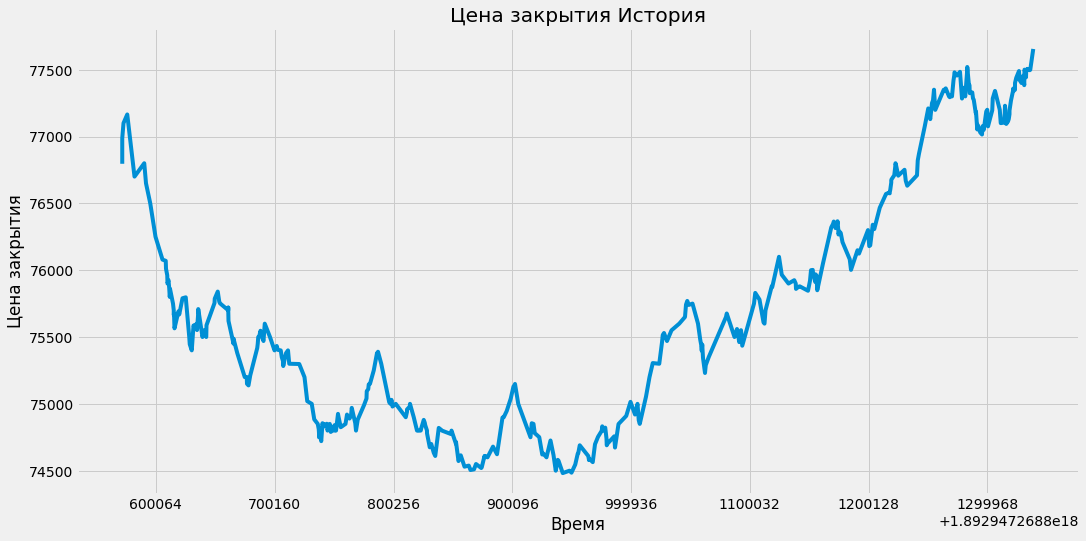

In [73]:
plt.figure(figsize = (16,8))
plt.title('Цена закрытия История')
plt.plot(df['Цена'])
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.show()

In [74]:
# Создаем новый датафрейм только с колонкой "Close"
data = df.filter(['Цена'])
# преобразовываем в нумпаевский массив
dataset = data.values
# Вытаскиваем количество строк в дате для обучения модели (LSTM)
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

#Scale the data (масштабируем)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset) 
#scaled_data.head

In [ ]:
# Создаем датасет для обучения
train_data = scaled_data[0:training_data_len]
# разбиваем на x underscore train и y underscore train 
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

#Конвертируем x_train и y_train в нумпаевский массив
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],x_train.shape[2]))

#Строим нейронку
model = Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

#Тренируем модель
model.fit(x_train,y_train,batch_size = 1, epochs = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


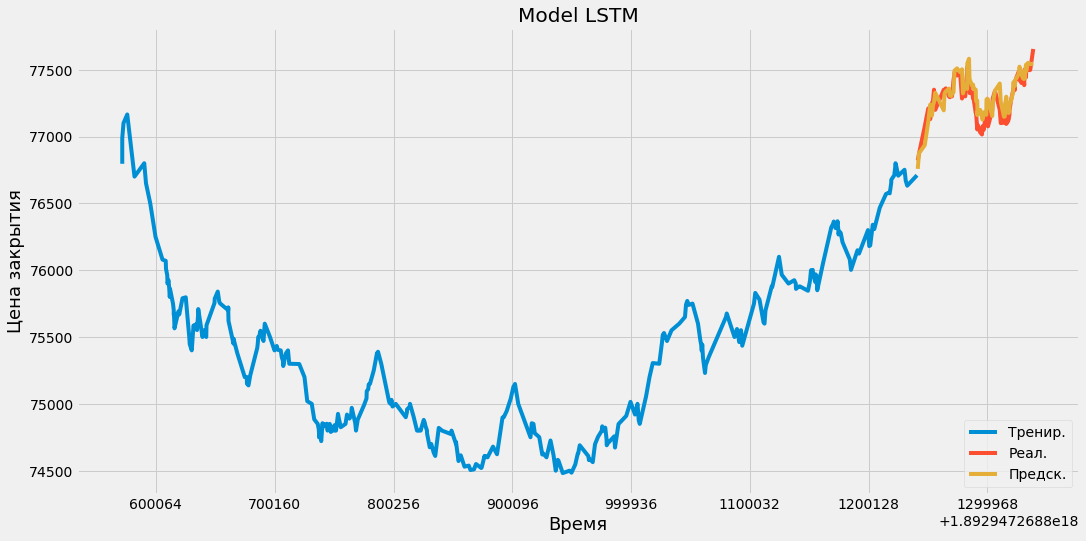

In [77]:
#Создаем тестовый датасет
test_data = scaled_data[training_data_len - 60:]
#по аналогии создаем x_test и y_test 
x_test = []
y_test = dataset[training_data_len:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i])

#опять преобразуем в нумпаевский массив
x_test = np.array(x_test)

#опять делаем reshape
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

#Получаем модель предсказывающую значения
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Получим mean squared error (RMSE) - метод наименьших квадратов
rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse



#Строим график
train = data[:training_data_len]
valid = data[training_data_len: ]
valid['Предсказания'] = predictions
#Визуализируем
plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Время', fontsize = 18)
plt.ylabel('Цена закрытия',fontsize = 18)
plt.plot(train['Цена'])
plt.plot(valid[['Цена','Предсказания']])
plt.legend(['Тренир.','Реал.','Предск.'], loc = 'lower right')
plt.show()

In [ ]:
valid.head(5)